Background: 

An online news portal aims to expand its business by acquiring new subscribers. Every visitor to the website takes certain actions based on their interest. The company plans to analyze these interests and wants to determine whether a new feature will be effective or not. Companies often analyze users' responses to two variants of a product to decide which of the two variants is more effective. This experimental technique is known as a/b testing that is used to determine whether a new feature attracts users based on a chosen metric.

Suppose you are hired as a Data Scientist in E-news Express. The design team of the company has created a new landing page. You have been assigned the task to decide whether the new landing page is more effective to gather new subscribers. Suppose you randomly selected 100 users and divided them equally into two groups. The old landing page is served to the first group (control group) and the new landing page is served to the second group (treatment group). Various data about the customers in both groups are collected in 'abtest.csv'. Perform the statistical analysis to answer the following questions using the collected data.

Objective:

Statistical analysis of business data. Explore the dataset and extract insights from the data. The idea is for you to get comfortable with doing statistical analysis in Python.

You are expected to perform the statistical analysis to answer the following questions:

* 1- Explore the dataset and extract insights using Exploratory Data Analysis.

* 2- Do the users spend more time on the new landing page than the old landing page?

* 3- Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than  the conversion rate for the old page?

* 4- Does the converted status depend on the preferred language? [Hint: Create a contingency table using the pandas.crosstab() function]

* 5- Is the mean time spent on the new page same for the different language users?

*Consider a significance level of 0.05 for all tests.

Data Dictionary:

user_id - This represents the user ID of the person visiting the website.

group - This represents whether the user belongs to the first group (control) or the second group (treatment).

landing_page - This represents whether the landing page is new or old.

time_spent_on_the_page - This represents the time (in minutes) spent by the user on the landing page.

converted - This represents whether the user gets converted to a subscriber of the news portal or not.

language_preferred - This represents the language chosen by the user to view the landing page.

In [1]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import scipy.stats as stats

In [2]:
#loading the file into data
data = pd.read_csv('abtest.csv')
df = data.copy() # making a copy of the initial dataset in order to preserve an original intact
df.head()#checking 

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


# 1 Dataset exploration - Univariate and Bivariate analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


In [4]:
df.shape

(100, 6)

In [5]:
df.isnull().sum()

user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64

#### Observations : 

    - dataset is clean with no null values
    
    - dataset contains 100 rows (users) and 6 columns (5 variables + 1useridcolumn)
    
    - 5 variables of which 1 is continuous variable and 4 are discrete variables
          
    - continuous variable is float type, which is ok, but the 4 categorical variables are of object type. 
    
    - need to change object type into category type for easier forward manipulation.


In [6]:
df['group'] = df['group'].astype('category')#convert type into category

In [7]:
df['landing_page'] = df['landing_page'].astype('category')#convert type into category

In [8]:
df['converted'] = df['converted'].astype('category')#convert type into category

In [9]:
df['language_preferred'] = df['language_preferred'].astype('category')#convert type into category

In [10]:
df['group'].unique() #checking the different options of this categorical variable

['control', 'treatment']
Categories (2, object): ['control', 'treatment']

In [11]:
df['converted'].unique() #checking the different options of this categorical variable

['no', 'yes']
Categories (2, object): ['no', 'yes']

In [12]:
df['landing_page'].unique() #checking the different options of this categorical variable

['old', 'new']
Categories (2, object): ['old', 'new']

In [13]:
df['language_preferred'].unique() #checking the different options of this categorical variable

['Spanish', 'English', 'French']
Categories (3, object): ['Spanish', 'English', 'French']

In [14]:
#Making a list of all categorical variables 
cat_col=['group', 'landing_page', 'converted', 'language_preferred']

#Printing number of count of each unique value in each column
for column in cat_col:
    print(df[column].value_counts())
    print('-'*50)

treatment    50
control      50
Name: group, dtype: int64
--------------------------------------------------
old    50
new    50
Name: landing_page, dtype: int64
--------------------------------------------------
yes    54
no     46
Name: converted, dtype: int64
--------------------------------------------------
Spanish    34
French     34
English    32
Name: language_preferred, dtype: int64
--------------------------------------------------


### Observations : 

the four categorical variables looks binomial. 

groups looks equally splitted between different category. All the groups are over 30, which may help use of the Central Limit Theorem, if needed.


In [15]:
def histogram_boxplot(data, feature, kde=True, figsize=(12, 7), bins=None):
    """
    Boxplot and histogram combined
    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    mode = data[feature].mode()
    
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    ax_hist2.axvline(mode[0], color="red", linestyle='-')
        #Add mode to the histogram

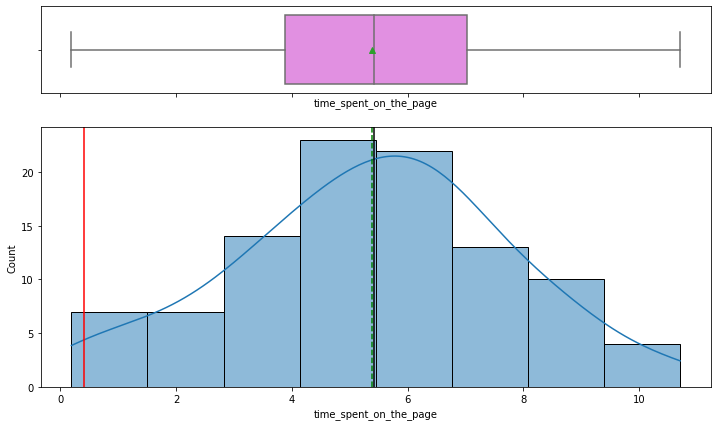

In [16]:
histogram_boxplot(data=df, feature='time_spent_on_the_page')

#### Observations : 

the time_spent_on_the_page variable looks to be normally distributed. The bell curve is classical. Median, Mode and Mean are equal. This will help use of normal distribution caracteristics later on. 

There are no outliers. 

In [17]:
def labeled_boxplot(data, feature1, feature2, feature3):
    
    #building arrays with median, quantile25 and quantile75 values of our sample
    median = data.groupby(by=[feature1, feature2])[feature3].median().values
    quantile25 = data.groupby(by=[feature1, feature2])[feature3].quantile(q=0.25).values
    quantile75 = data.groupby(by=[feature1, feature2])[feature3].quantile(q=0.75).values
    
    #reordering data within arrays (boxplot and groupby are not ordering values in the same way)
    median_array = (median[1], median[0], median[3], median[2])
    quantile25_array = (quantile25[1], quantile25[0], quantile25[3], quantile25[2])
    quantile75_array = (quantile75[1], quantile75[0], quantile75[3], quantile75[2])
    
    #Boxploting Gender, MaritalStatus and feature for data
    ax = sns.boxplot(x=feature1, y=feature3, hue=feature2, data=data)
    
    #putting into variables the median, quantile25 and quantile75
    a = median_array 
    b = quantile25_array
    c = quantile75_array

    #implementing counter
    ind = 0
    #showing Median value on boxplot

    for tick in range(len(ax.get_xticklabels())):
        ax.text(tick-.2, a[ind+1], a[ind+1], horizontalalignment='center', size=10, color='b')
        ax.text(tick+.2, a[ind], a[ind], horizontalalignment='center', size=10, color='b')
        ind+=2
    
    #showing quantile25 on Boxplot
    ind = 0
    for tick in range(len(ax.get_xticklabels())):
        ax.text(tick-.4, b[ind+1], b[ind+1], horizontalalignment='left', size=10, color='b')
        ax.text(tick, b[ind], b[ind], horizontalalignment='left', size=10, color='b')
        ind+=2

    #showing quantile75 on Boxplot
    ind=0
    for tick in range(len(ax.get_xticklabels())):
        ax.text(tick-.4, c[ind+1], c[ind+1], horizontalalignment='left', size=10, color='b')
        ax.text(tick, c[ind], c[ind], horizontalalignment='left', size=10, color='b')
        ind+=2
    
    plt.show()

In [18]:
def labeled_boxplot3(data, feature1, feature2, feature3):
    
    #building arrays with median, quantile25 and quantile75 values of our sample
    median = data.groupby(by=[feature1, feature2])[feature3].median().values
    quantile25 = data.groupby(by=[feature1, feature2])[feature3].quantile(q=0.25).values
    quantile75 = data.groupby(by=[feature1, feature2])[feature3].quantile(q=0.75).values
    
    #reordering data within arrays (boxplot and groupby are not ordering values in the same way)
    median_array = (median[2], median[1], median[0], median[5], median[4], median[3])
    quantile25_array = (round(quantile25[2],2), round(quantile25[1],2), round(quantile25[0],2), round(quantile25[5],2), round(quantile25[4],2), round(quantile25[3],2))
    quantile75_array = (round(quantile75[2],2), round(quantile75[1],2), round(quantile75[0],2), round(quantile75[5],2), round(quantile75[4],2), round(quantile75[3],2))
    
    #Boxploting Gender, MaritalStatus and feature for data
    ax = sns.boxplot(x=feature1, y=feature3, hue=feature2, data=data)
    
    #putting into variables the median, quantile25 and quantile75
    a = median_array 
    b = quantile25_array
    c = quantile75_array

    #implementing counter
    ind = 0
    #showing Median value on boxplot

    for tick in range(len(ax.get_xticklabels())):
        ax.text(tick+0.3, a[ind], a[ind], horizontalalignment='center', size=10, color='b')
        ax.text(tick, a[ind+1], a[ind+1], horizontalalignment='center', size=10, color='b')
        ax.text(tick-0.3, a[ind+2], a[ind+2], horizontalalignment='center', size=10, color='b')
        ind+=3
    
    #showing quantile25 on Boxplot
    ind = 0
    for tick in range(len(ax.get_xticklabels())):
        ax.text(tick-.3, b[ind+2], b[ind+2], horizontalalignment='center', size=10, color='b')
        ax.text(tick, b[ind+1], b[ind+1], horizontalalignment='center', size=10, color='b')
        ax.text(tick+.3, b[ind], b[ind], horizontalalignment='center', size=10, color='b')
        ind+=3

    #showing quantile75 on Boxplot
    ind=0
    for tick in range(len(ax.get_xticklabels())):
        ax.text(tick-.3, c[ind+2], c[ind+2], horizontalalignment='center', size=10, color='b')
        ax.text(tick, c[ind+1], c[ind+1], horizontalalignment='center', size=10, color='b')
        ax.text(tick+.3, c[ind], c[ind], horizontalalignment='center', size=10, color='b')
        ind+=3
    
    plt.show()

In [19]:
#defining a function to compare discrete variables
def feature_interactions(df,feature1, feature2,continuous_col):
    #selecting the group of data needed with the 2 discrete variable (feature1, feature2) and the continuous one (continuous col)
    group = df.groupby([feature1,feature2],as_index=False)[continuous_col].mean().reset_index(drop=True)
    #pivoting table with feature 1 as y and feature 2 as x
    pivot = group.pivot(index=feature1, columns=feature2, values=continuous_col)
    #sizing the figure
    plt.figure(figsize=(10,6))
    #ploting with heatmap
    sns.heatmap(pivot,cmap='Reds')
    #showing the graph
    plt.show()

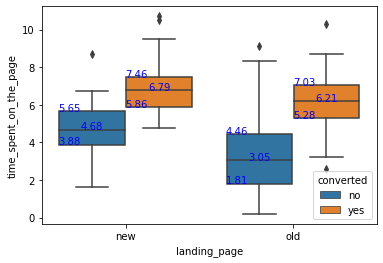

In [20]:
labeled_boxplot(df, feature1='landing_page', feature2='converted',feature3='time_spent_on_the_page')

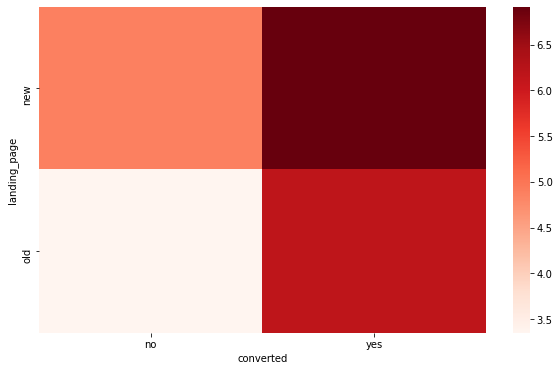

In [21]:
feature_interactions(df, feature1='landing_page', feature2='converted', continuous_col='time_spent_on_the_page')

Observations : 

- time_spent_on_the_page looks to be higher for the converted vs the not converted ones. This is the same whether the page is the new one or the old one, meaning treatment and control groups. 

- time spent between old page and new page looks to be different, but this have to be confirmed later.


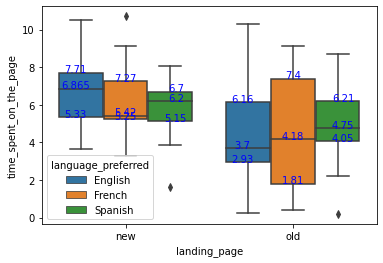

In [22]:
labeled_boxplot3(df, feature1='landing_page', feature2='language_preferred',feature3='time_spent_on_the_page')

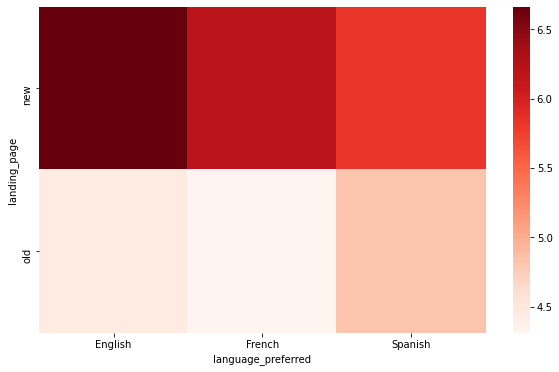

In [23]:
feature_interactions(df, feature1='landing_page', feature2='language_preferred', continuous_col='time_spent_on_the_page')

Observations : 

- globally it confirms previous observation, meaning time_spent_on_the_page is higher for the new page than the old page. 

- it looks to be some differences between preferred language users, but difficult to say if it's significant at this stage.

- few outliers. 


Conclusions : 

- Data are clean with no null values

- Data looks equally splitted between groups and each have more than 30 constituants

- the continuous variable (time_spent_on_the_page) looks to be normally distributed. 

- it looks to be some differences between new and old page landing in time spent. This has to be confirmed. 

- it looks to be some differences between new and old page landing in time spent depending on preferred_languages. This has to be confirmed. 

- it looks that there could be some differences between the converted and the time spend. This has to be confirmed.


# 2 Do the users spent more time on the new landing page than the old landing page?

In [24]:
df1 = pd.get_dummies(data=df, columns=['landing_page'])#transforming the categorical variable column 'landing_page' for further treatment
df1.head()#checking results

,user_id,group,time_spent_on_the_page,converted,language_preferred,landing_page_new,landing_page_old
0,546592,control,3.48,no,Spanish,0,1
1,546468,treatment,7.13,yes,English,1,0
2,546462,treatment,4.40,no,Spanish,1,0
3,546567,control,3.02,no,French,0,1
4,546459,treatment,4.75,yes,Spanish,1,0


In [25]:
df2 = df1.filter(items=['time_spent_on_the_page','landing_page_old'])#keeping the continuous variable column and the categorical one
df2.head()#checking

,time_spent_on_the_page,landing_page_old
0,3.48,1
1,7.13,0
2,4.40,0
3,3.02,1
4,4.75,0


In [26]:
df3 = df2.query('landing_page_old==1')#selecting the landing_page_old users
df3.head()#checking

,time_spent_on_the_page,landing_page_old
0,3.48,1
3,3.02,1
5,5.28,1
7,6.53,1
9,2.08,1


In [60]:
#printing the mean, var and std values of the first sample
a = df3['time_spent_on_the_page'].mean()
b= df3['time_spent_on_the_page'].var()
c = df3['time_spent_on_the_page'].std()
print('the time spent mean of the landing old page users is :', round(a, 4))
print('the time spent var of the landing old page users is :', round(b, 4))
print('the time spent standard deviation of the landing old page users is :', round(c, 4))

the time spent mean of the landing old page users is : 4.5324
the time spent var of the landing old page users is : 6.6666
the time spent standard deviation of the landing old page users is : 2.582


In [28]:
df4 = df1.filter(items=['time_spent_on_the_page','landing_page_new'])#selecting continuous variable column and categorical variable column
df5 = df4.query('landing_page_new==1')#selecting the landing_page_new users
df5.head()#checking

,time_spent_on_the_page,landing_page_new
1,7.13,1
2,4.40,1
4,4.75,1
6,5.25,1
8,10.71,1


In [61]:
d = df5['time_spent_on_the_page'].mean()
e = df5['time_spent_on_the_page'].var()
f = df5['time_spent_on_the_page'].std()
print('the time spent mean of the landing new page users is :', round(d, 4))
print('the time spent var of the landing new page users is :', round(e, 4))
print('the time spent standard deviation of the landing new page users is :', round(f , 4))

the time spent mean of the landing new page users is : 6.2232
the time spent var of the landing new page users is : 3.3016
the time spent standard deviation of the landing new page users is : 1.817


In [30]:
df3['time_spent_on_the_page'].count()#checking the number of observations on sample 1

50

In [31]:
df5['time_spent_on_the_page'].count()#checking the number of observations on sample 2

50

Taking into account that we are comparing two means of a continuous variable, with a known variance/standard deviation, we will perform a one-tailed Z-test.

### Null and alternative hypothesis


Let  𝜇  be the mean time spent on the page. 

𝜇1 : mean time spent of the new landing page users

𝜇2 : mean time spent of the old landing page users

The nul hypothesis is equality of means, in other words there is no difference in time spent between the two groups

>$𝐻o:𝜇1=𝜇2$

The alternate Hypothesis is the time spent mean of the new page users is higher than the old page ones.

>$𝐻𝑎:𝜇1>𝜇2$

### Z-test assumptions checking

Continuous data - The time spent on the page are measured on a continuous scale.

Normally distributed populations or Sample sizes > 30 - Since the sample sizes are greater than 30, Central Limit Theorem states that the distribution of sample means will be normal.

Independent populations - As we are taking samples for two different users (control/treatment, converted yes/no), the two samples are from two independent populations.

Known population standard deviation  𝜎1  and  𝜎2  - Yes, we know the population standard deviations of both populations.

Random sampling from the population - Yes, we are informed that the collected sample is a simple random sample.

### pvalue calculation

In [62]:
# user-defined function to compare the equality of two means from two independent populations, where population standard deviations are known
# this function returns the p-value for one tailed test
# for two-tailed test, multiply the p-value by 2
# To know more about the derivation of test statistic and standard error formula, please refer to the monographs and additional materials
def ztest_2samp(X1, X2, pop_sd1, pop_sd2, n1, n2):
    '''
    X1 - first of the two independent samples (sample 1)
    X2 - second of the two independent samples (sample 2)
    pop_sd1 - population standard deviation of sample 1
    pop_sd2 - population standard deviation of sample 2
    n1 - size of sample 1
    n2 - size of sample 2
    '''
    from numpy import sqrt, abs # import the required functions
    from scipy.stats import norm # import the required function
    se = sqrt(pop_sd1**2/n1 + pop_sd2**2/n2) # calculate the standard error
    test_stat = ((X1.mean() - X2.mean()) - 0)/ se # calculate the test statistic
    pval = 1 - norm.cdf(abs(test_stat)) # calculate the one-tailed p-value
    return print('the pvalue is :', pval, 'the test_stat is :', round(test_stat, 4)) # return the p-value and test stat value

In [63]:
#performing a ztest on the 2 sample to determine the p_value
ztest_2samp(df5['time_spent_on_the_page'], df3['time_spent_on_the_page'], df5['time_spent_on_the_page'].std(), df3['time_spent_on_the_page'].std(), 50, 50)


the pvalue is : 7.630904034416908e-05 the test_stat is : 3.7868


### Graphic Approach

In [34]:
# import the required function
from scipy.stats import norm

# find the critical value
critical_val = norm.ppf(1-.05)
print('the critical val is {}'.format(round((critical_val), 4)))

the critical val is 1.6449


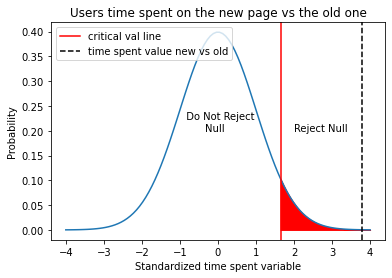

In [77]:
# plotting the test statistic distribution and indicating the rejection and acceptance region
# We are plotting the distributions here to better visualize the calculations
x = np.linspace(-4, 4, 100) # create an array of 100 numbers starting from -4 and ending at 4
plt.plot(x, norm.pdf(x, 0, 1)) # plot the pdf of the normal distribution
plt.axvline(x = critical_val, c = 'r', label='critical val line') # draw a vertical red line through the mentioned point
x1 = np.linspace(critical_val, 4, 50) # create an array of 50 numbers starting from the critical value and ending at 4
plt.fill_between(x1, norm.pdf(x1, 0, 1), color='red') # fill the area under the curve after the critical value with red color
#draw a vertical line on test var value and label it for legend issue
plt.axvline(x=3.7867, linestyle='--', color='black', label='time spent value new vs old')
plt.xlabel('Standardized time spent variable') #adding legend on x axis
plt.ylabel('Probability')#adding legend on y axis
plt.annotate('Reject Null', (2, 0.20)) # annotate the mentioned text at the mentioned location
plt.annotate('  Do Not Reject\n        Null', (-1, 0.20)) # annotate the mentioned text at the mentioned location
plt.legend(loc=2)#printing legend on upper left corner
plt.title('Users time spent on the new page vs the old one')#adding title
plt.show() # display the plot

### Conclusion :

pvalue is far below the level of significance (5%). Thus we can reject the Null Hypothesis. The alternative Hypothesis is validated. So we can say that the time spent, in average, on the page by the users is higher on the new page than the old one.

The graphic approach confirm this conclusion the tested var is in the null rejection region.

## 3 Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than  the conversion rate for the old page?

In [36]:
#determining the number of converted users between the new_landing_page and the old_landing_page
df.groupby(by=['converted','landing_page'])['time_spent_on_the_page'].count()

converted  landing_page
no         new             17
           old             29
yes        new             33
           old             21
Name: time_spent_on_the_page, dtype: int64

Taking into account that we are comparing two proportions of two dicrete variables, we will perform a two proportion Z-test

#### Null and alternative Hypothesis

let p1 the proportion of new page converted and p2 the proportion of old page converted

>$Ho : p1=p2$

There is no difference between p1 and p2.

>$Ha : p1 > p2$

The conversion rate is greater with new page versus old page

#### Z-test assumptions checking

Binomally distributed population - Yes, a converted user can be either on the new page or the old page.

Random sampling from the population - Yes, we are informed that the collected sample is a simple random sample.

Can the binomial distribution approximated to normal distribution - Yes. For binary data, CLT works slower than usual. The standard thing is to check whether np and n(1-p) are greater than or equal to 10. Here, n and p refer to the sample size and sample proportion respectively.

>$ np_1=50 \cdot \cfrac {33} {50} = 33 \geq10 \\
n(1-p_1)=50 \cdot \frac {50-33} {50} = 17 \geq 10 \\
np_2=50 \cdot \cfrac {21} {50} = 21 \geq 10 \\
n(1-p_2)=50 \cdot \cfrac {50-21} {50} = 29 \geq 10 $

In [76]:
#import the appropriate function
from statsmodels.stats.proportion import proportions_ztest

#build an array with the converted new and old page
converted_count = np.array([33,21])

#build an array with the total count of each group
nobs = np.array([50,50])

#pvalue calculation
test_var, p_value = proportions_ztest(converted_count, nobs)
#printing pvalue
print('the pvalue is {}'.format(round(p_value,4)))

the pvalue is 0.0161


### Graphic Approach

In [38]:
# import the required function
from scipy.stats import norm

# find the critical value
critical_val = norm.ppf(1-.05)
print('the critical val is {}'.format(round((critical_val), 4)))

the critical val is 1.6449


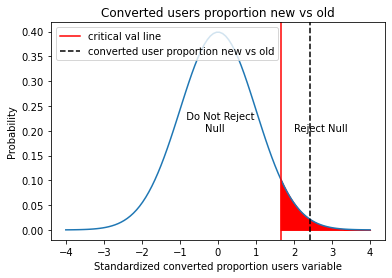

In [39]:
# plotting the test statistic distribution and indicating the rejection and acceptance region
# We are plotting the distributions here to better visualize the calculations
x = np.linspace(-4, 4, 100) # create an array of 100 numbers starting from -4 and ending at 4
plt.plot(x, norm.pdf(x, 0, 1)) # plot the pdf of the normal distribution
plt.axvline(x = critical_val, c = 'r', label='critical val line') # draw a vertical red line through the mentioned point
x1 = np.linspace(critical_val, 4, 50) # create an array of 50 numbers starting from the critical value and ending at 4
plt.fill_between(x1, norm.pdf(x1, 0, 1), color='red') # fill the area under the curve after the critical value with red color
plt.axvline(x=test_var, linestyle='--', color='black', label='converted user proportion new vs old')
plt.xlabel('Standardized converted proportion users variable')
plt.ylabel('Probability')
plt.annotate('Reject Null', (2, 0.20)) # annotate the mentioned text at the mentioned location
plt.annotate('  Do Not Reject\n        Null', (-1, 0.20)) # annotate the mentioned text at the mentioned location
plt.legend(loc=2)
plt.title('Converted users proportion new vs old')
plt.show() # display the plot

#### Conclusion

pvalue is far below the 5% significance level. So we can reject the null Hypothesis. Thus, the alternative one is validated. The conversion rate is higher with the new page than the old page. 

The graphic approach confirm this conclusion as the tested variable is in the reject null region.


## 4- Does the converted status depend on the preferred language? [Hint: Create a contingency table using the pandas.crosstab() function]

In [40]:
#preparing the contingency table
cont_table= pd.crosstab(df['language_preferred'],df['converted'])
cont_table.head()

converted,no,yes
language_preferred,,
English,11,21
French,19,15
Spanish,16,18


Taking into account that we are studying the independency of two discrete variables, we will perform a Chi Square test of independence

#### Hypothesis

We will test the null hypothesis

>$ Ho : converted \ status \ is \ independent \ from \ preferred \ language $

Against the alternative one

>$ Ha : converted \ status \ is \ NOT \ independent \ from \ preferred \ language $


#### Assumptions

* Categorical variables - Yes
* Expected value of the number of sample observations in each level of the variable is at least 5 - Yes, the number of observations in each level is greater than 5.
* Random sampling from the population - Yes, we are informed that the collected sample is a simple random sample.


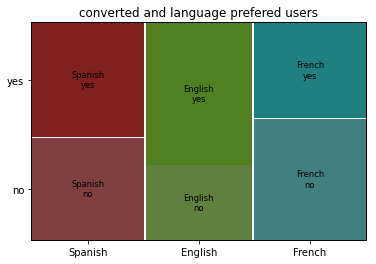

In [41]:
from statsmodels.graphics.mosaicplot import mosaic
data = df.filter(items=['language_preferred','converted'])
mosaic(data, ['language_preferred','converted'], title='converted and language prefered users')
plt.show()

In [42]:
#import the required functions
from scipy.stats import chi2_contingency

chi, p_value, dof, expected = chi2_contingency(cont_table)
print('The p-value is ', p_value)

The p-value is  0.2129888748754345


#### Conclusions

p_value is higher than the 5% relevance (alpha). So we cannot reject the null hypothesis. Converted Status is independent from preferred language of the users.

 ## 5- Is the mean time spent on the new page same for the different language users?

In [43]:
#selecting the columns time_spent_on_the_page, language_preferred and landing_page_new
df6 = df1.filter(items=(['time_spent_on_the_page', 'language_preferred', 'landing_page_new']))
df6.head()#checking results

,time_spent_on_the_page,language_preferred,landing_page_new
0,3.48,Spanish,0
1,7.13,English,1
2,4.40,Spanish,1
3,3.02,French,0
4,4.75,Spanish,1


In [44]:
#selecting only the landing_page_new users
df7 = df6.query('landing_page_new==1')
df7.head()#checking

,time_spent_on_the_page,language_preferred,landing_page_new
1,7.13,English,1
2,4.40,Spanish,1
4,4.75,Spanish,1
6,5.25,French,1
8,10.71,French,1


In [45]:
#determining the 3 time_spent_on_the_page means for each language_preferred subgroup
df7.groupby('language_preferred')['time_spent_on_the_page'].mean()

language_preferred
English    6.663750
French     6.196471
Spanish    5.835294
Name: time_spent_on_the_page, dtype: float64

As we will compare more than two means of continuous variable depending on a dicrete one, we will perform an ANOVA test.

#### Hypothesis to be tested

Let $\mu_1, \mu_2, \mu_3$ be the means of time spent for english preferred language users, french preferred language users and spanish preferred language users respectively.

We will test the null hypothesis

>$H_0: \mu_1 = \mu_2 = \mu_3$

against the alternative hypothesis

>$H_a: $ At least one time spent mean is different from the rest.

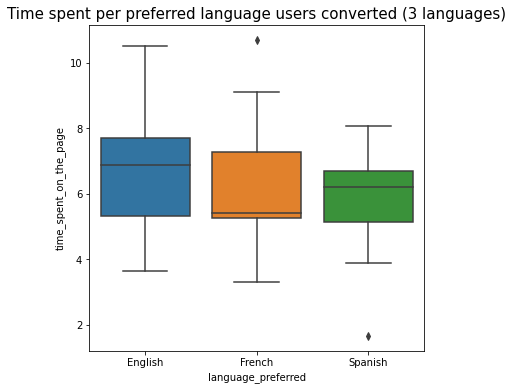

In [46]:
fig, ax = plt.subplots(figsize = (6,6))
a = sns.boxplot(x= "language_preferred", y = 'time_spent_on_the_page' , data = df7)
a.set_title("Time spent per preferred language users converted (3 languages)", fontsize=15)
plt.show()

#### Observations

visually speaking the means looks quite different. However, when it comes to numbers ( $\mu_1 =6.663750, \mu_2 = 6.196471, \mu_3 = 5.835294$) this is not so obvious. 


Now, the normality and equality of variance assumptions need to be checked. 

* For testing of normality, Shapiro-Wilk’s test is applied to the response variable.

* For equality of variance, Levene test is applied to the response variable.

#### Shapiro-Wilk’s test
We will test the null hypothesis

>$𝐻o:  time \ spent \ on \ the \ page \ follows \ a \ normal \ distribution \ against$

against the alternative hypothesis

>$𝐻𝑎:  time \ spent \ on \ the \ page \ does \ not \ follow \ a \ normal \ distribution$

In [47]:
# Assumption 1: Normality
# import the required function
from scipy import stats

# find the p-value
w, p_value = stats.shapiro(df7['time_spent_on_the_page']) 
print('The p-value is', p_value)

The p-value is 0.8040016293525696


#### Observations : 

* the pvalue is far higher than the 5% significance level. Thus, we cannot reject the Null Hypothesis. So the time spent on the page follows a normal distribution

#### Levene’s test

We will test the null hypothesis

> $𝐻o : All \ the \ population \ variances \ are \ equal $

against the alternative hypothesis

> $𝐻𝑎 : At \ least \ one \ variance \ is \ different \ from \ the \ rest $

In [48]:
#Assumption 2: Homogeneity of Variance
#import the required function
from scipy.stats import levene
statistic, p_value = levene( df7['time_spent_on_the_page'][df7['language_preferred']=="English"], 
                                   df7['time_spent_on_the_page'][df7['language_preferred']=="French"], 
                                   df7['time_spent_on_the_page'][df7['language_preferred']=="Spanish"])
# find the p-value
print('The p-value is', p_value)

The p-value is 0.46711357711340173


#### Observations

* the pvalue is far higher than the 5% level of signicance (alpha). Thus we cannot reject the null hypothesis. The time spent on the page variable variances are equal.


### Assumptions checking

* The populations are normally distributed - Yes, the normality assumption is verified using the Shapiro-Wilk’s test.
* Samples are independent simple random samples - Yes, we are informed that the collected sample is a simple random sample.
* Population variances are equal - Yes, the homogeneity of variance assumption is verified using the Levene's test.

### pvalue calculation

In [49]:
#import the required function
from scipy.stats import f_oneway

# perform one-way anova test
test_stat, p_value = f_oneway(df7.loc[df7['language_preferred'] == 'English', 'time_spent_on_the_page'],
                              df7.loc[df7['language_preferred'] == 'French', 'time_spent_on_the_page'],
                              df7.loc[df7['language_preferred'] == 'Spanish', 'time_spent_on_the_page'])
print('The p-value is ' + str(p_value))

The p-value is 0.43204138694325955


### Graphic Approach

In [50]:
# import the required function
from scipy.stats import norm

# find the critical values
critical_val1 = norm.ppf(1-.05/2)
critical_val2 = norm.ppf(0.05/2)
print('the first critical val is {}'.format(round((critical_val1), 4)))
print('the second critical val is {}'.format(round((critical_val2), 4)))

the first critical val is 1.96
the second critical val is -1.96


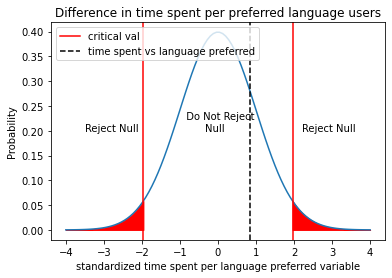

In [51]:
# plot the rejection and acceptance region
# We are plotting the distributions here to better visualize the calculations
x = np.linspace(-4, 4, 100) # create an array of 100 numbers starting from -4 and ending at 4
plt.plot(x, norm.pdf(x, 0, 1)) # plot the pdf of the normal distribution
plt.axvline(x = critical_val1, c = 'r', label='critical val') # draw a vertical red line through the mentioned point
x1 = np.linspace(critical_val1, 4, 50) # create an array of 50 numbers starting from the critical value and ending at 4
plt.fill_between(x1, norm.pdf(x1, 0, 1), color='r') # fill the area under the curve after the critical value with red color
plt.axvline(x = critical_val2, c = 'r') # draw a vertical red line through the mentioned point
x1 = np.linspace(-4, critical_val2, 50) # create an array of 50 numbers starting from -4 and ending at the critical value
plt.fill_between(x1, norm.pdf(x1, 0, 1), color='r') # fill the area under the curve before the critical value with red color
plt.axvline(x=test_stat, linestyle='--', color='black', label='time spent vs language preferred')
plt.annotate('Reject Null', (2.2, 0.20)) # annotate the mentioned text at the mentioned location
plt.annotate('Reject Null', (-3.5, 0.20)) # annotate the mentioned text at the mentioned location
plt.annotate('  Do Not Reject\n        Null', (-1, 0.20)) # annotate the mentioned text at the mentioned location
plt.xlabel('standardized time spent per language preferred variable')
plt.ylabel('Probability')
plt.title('Difference in time spent per preferred language users')
plt.legend(loc=2)
plt.show() # display the plot

### Conclusions

* pvalue is far higher than the 5% significance level. Thus, we cannot reject the null hypothesis. So the mean time spent on the page per preferred language group are equals. There is no differences between the different subgroup.

* the graphic approach confirm this conclusion

### Business Conclusions

* The time spent by users, in average, is higher on the new page than the old one
* The new page has a higher conversion rate than the old one
* There is no relation between the conversion rate and the preferred language of users
* The users spent the same time, in average, on the new page whatever their preferred language is. In other words, there is no preferred language/culture discrimination. All preferred language users feel confortable with the new page.

This reinforce the quality of new page vs the old one. thus, this is a validation of the new page.

Therefore, we recommand to implement the new page as the official new one and to ban the old one. 

This new page is multicultural, multi_language, which makes it accessible by a wide range of users. Thus this strengthen the communication policy of the company towards any users. 

#### Deeper Analysis : 

We recommand to test other preferred language in order to check the acceptance of the new page by other culture users. 